# Molybdenum doped Vanadium Dioxide Data

We will be comparing the result of standard punch and fill to that of the technique involving watershed segmentation of the Bragg peaks followed by Laplacian and Matern fill. 

The data can be found on nxrs:
`/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs`

From Matt: the most relevant scattering is found half-integer L planes, with only weak size-effect scattering close to the Bragg peaks; a 3D-deltaPDF should show a clear 2D 'X' pattern.

In [1]:
# Set up directories for {Charlotte,Vishwas}'s machine.
# The repo_dir and base_dir are customized for Charlotte's and Vishwas' laptops.
# repo_dir corresponds to the directory where the git repo 'laplaceinterpolation' is saved.
from   pathlib import Path
import socket
home = str(Path.home())
hostname = str(socket.gethostname())

# If not Charlotte's home, Vishwas's home
if home == '/Users/charlottehaley':
    base_dir = home + '/Documents/Data/Xray/md_54_4b/'
    repo_dir = home + '/Documents/Repos/LaplaceInterpolation.jl/'
if home == '/Users/vishwasrao':
    base_dir = home +'/Research/BES_Project/Data/'
    #repo_dir = home + '/Research/BES_Project/Repo/LaplaceInterpolation.jl/'
    repo_dir = home + '/Github/LaplaceInterpolation.jl/'

save_data_dir = base_dir

# filename and filename_background customized to work on Charlotte's and Vishwas's laptops and on nxrs.
if "nxrs" in hostname and "nxrs0" not in hostname:
    filename = '/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs'
    filename_background = '/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_background.nxs'
    save_data_dir = home
else:
    filename = base_dir + 'movo2_40_120K.nxs'
    filename_background = base_dir + 'movo2_40_background.nxs'

In [2]:
import sys
sys.path.insert(1, repo_dir)

import numpy as np
import matplotlib.pyplot as plt
from   scipy.interpolate import Rbf
from   nexusformat.nexus import *
from scipy.interpolate import RBFInterpolator

import scipy.signal
from   astropy.convolution import convolve, Kernel, Gaussian1DKernel
import math
import scipy.ndimage

from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton

import math, timeit

# This may work differently for you, note that julia v 1.5.4 should be used (v 1.6.0 is incompatible)
from julia import Julia
julia = Julia(compiled_modules=False)
from julia import Main
# This line requires that https://bitbucket.org/vishwasrao/LaplaceInterpolation.jl be added to 
# your julia installation (>julia using Pkg; Pkg.add("https://bitbucket.org/vishwasrao/LaplaceInterpolation.jl"))
from julia import LaplaceInterpolation
#julia.include(repo_dir+"/MaternKernelApproximation.jl")

def flipaxis(A,i):
    Aprime=np.swapaxes(np.swapaxes(A,0,i)[::-1],0,i)
    return Aprime

In [3]:
# Load data, print tree.
data = nxload(filename)
data.unlock()

movo2_40_background = nxload(filename_background)
movo2_40_background.unlock()

## Load the symmetric transform data

In [4]:
z3d = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxvalue 

## Initialize X, Y, Z and dX, dY, and dZ

In [5]:
# The markers should be the Bragg locations
x = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Ql.nxvalue
x2 = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Qk.nxvalue
x3 = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Qh.nxvalue

dx = x[1] - x[0]
dx2 = x2[1] - x2[0]
dx3 = x3[1] - x3[0]

## Define the symmetrizing operation and the standard punch

In [6]:
Qh_lim=8
Qk_lim=8
Ql_lim=6

kmin=50*(6-Ql_lim)
kmax=50*(6+Ql_lim)
jmin=50*(8-Qk_lim)
jmax=50*(8+Qk_lim)
imin=50*(8-Qh_lim)
imax=50*(8+Qh_lim)

def symmetrize(res):
    # This is a bit ad-hoc as the indices are hard-coded.
    vvals=np.zeros((601,801,801))
    vvals[290:601,390:801,390:801] = res
    vvals[300:601,400:801,0:401] = flipaxis(vvals[300:601,400:801,400:801],2)
    vvals[300:601,0:401,0:801] = flipaxis(vvals[300:601,400:801,0:801],1)
    vvals[0:301,0:801,0:801] = flipaxis(vvals[300:601,0:801,0:801],0)
    return vvals[0:600,0:800,0:800]

In [18]:
# Matern Interpolation happens here. 
epsilon = 0.0 # Regularization parameter
m = 2 # Matern parameter
#radius = 0.0 # Punch radius
radius = 0.2
h = 0.02 # grid spacing. For MoVO2, the grid spacing along all directions are the same.
# For other crystals, this might not be so. In that case, we have separate values of h,k,l.

xmin = 0
xmax = 6
ymin = 0
ymax = 8
zmin = 0
zmax = 8

# Here I've implemented the rule where depending on the symmetry group, some Bragg peaks are not punched
centers = LaplaceInterpolation.center_list('A', xmin, xmax, ymin, ymax, zmin, zmax)
centers

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 6, 0),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 6, 4),
 (0, 6, 5),
 (0, 6, 6),
 (0, 6, 7),
 (0, 6, 8),
 (0, 7, 0),
 (0, 7, 1),
 (0, 7, 2),
 (0, 7, 3),
 (0, 7, 4),
 (0, 7, 5),
 (0, 7, 6),
 (0, 7, 7),
 (0, 7, 8),
 (0, 8, 0),
 (0, 8, 1),
 (0, 8, 2),
 (0, 8, 3),
 (0, 8, 4),
 (0, 8, 5),
 (0, 8, 6),
 (0, 8, 7),
 (0, 8, 8),
 (1, 0, 0),
 (1, 0, 1),
 (1,

In [20]:
xbegin = ybegin = zbegin = -0.2
z3d_copy = np.copy(z3d) #Creating a copy to ensure the original is not overwritten.
z3d_punched = np.copy(z3d)
z3d_restored = np.copy(z3d) 
parallel_laplace_restored = np.copy(z3d)

stride = 10 
#discard = LaplaceInterpolation.punch_3D_cart(centers[1], (radius, radius, radius), x, x2, x3)


In [9]:
starttime = timeit.default_timer()
z3d_restored = LaplaceInterpolation.matern_w_punch(z3d, xmin, xmax, ymin, ymax, zmin, zmax, 
                                  (radius, radius, radius), x, x2, x3, m, epsilon, 1.0, 1.0, 1.0, 'A')
print("Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2:", timeit.default_timer() - starttime)

Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2: 351.781481145


In [10]:
starttime = timeit.default_timer()
z3d_restored = LaplaceInterpolation.matern_w_punch(z3d, xmin, xmax, ymin, ymax, zmin, zmax, 
                                  (radius, radius, radius), x, x2, x3, 1, 0.0, 1.0, 1.0, 1.0, 'A')
print("Time taken for Laplace interpolation with m = 1 and epsilon = 0, punch radius 0.2:", timeit.default_timer() - starttime)


Time taken for Laplace interpolation with m = 1 and epsilon = 0, punch radius 0.2: 193.01428514100002


In [21]:
starttime = timeit.default_timer()
for i in range(zmin, zmax+1):
    i1 = int((i - zbegin) / h) - stride 
    i2 = i1 + 2 * stride + 1 
    for j in range(ymin, ymax+1):
        j1 = int((j - ybegin) / h) - stride
        j2 = j1 + 2 * stride + 1 
        for k in range(xmin, xmax+1):
            k1 = int((k - xbegin) / h) - stride
            k2 = k1 + 2 * stride + 1 
            z3temp = z3d_copy[k1:k2, j1:j2, i1:i2] 
            absolute_indices = LaplaceInterpolation.punch_3D_cart([k,j,i], radius, x[k1:k2], x2[j1:j2], x3[i1:i2])
            restored_img = LaplaceInterpolation.matern_3d_grid(z3temp, absolute_indices,
                                                              m, epsilon, h, h, h) #h=k=l here
            z3d_restored[k1:k2, j1:j2, i1:i2] = restored_img 
            
            
print("Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2:", timeit.default_timer() - starttime)

Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2: 100.90076320500066


In [22]:
starttime = timeit.default_timer()
for i in range(zmin, zmax+1):
    i1 = int((i - zbegin) / h) - stride
    i2 = i1 + 2 * stride + 1 
    for j in range(ymin, ymax+1):
        j1 = int((j - ybegin) / h) - stride
        j2 = j1 + 2 * stride + 1 
        for k in range(xmin, xmax+1):
            k1 = int((k - xbegin) / h) - stride
            k2 = k1 + 2 * stride + 1 
            z3temp = z3d_copy[k1:k2, j1:j2, i1:i2] 
            absolute_indices = LaplaceInterpolation.punch_3D_cart([k,j,i], radius, x[k1:k2], x2[j1:j2], x3[i1:i2], linear = True)
            restored_img = LaplaceInterpolation.matern_3d_grid(z3temp, absolute_indices,
                                                              1, 0.0, h, h, h) #h=k=l here
            parallel_laplace_restored[k1:k2, j1:j2, i1:i2] = restored_img            
            
print("Time taken for Laplace interpolation with m = 1 and epsilon = 0, punch radius 0.2:", timeit.default_timer() - starttime)


Time taken for Laplace interpolation with m = 1 and epsilon = 0, punch radius 0.2: 23.86482623899974


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


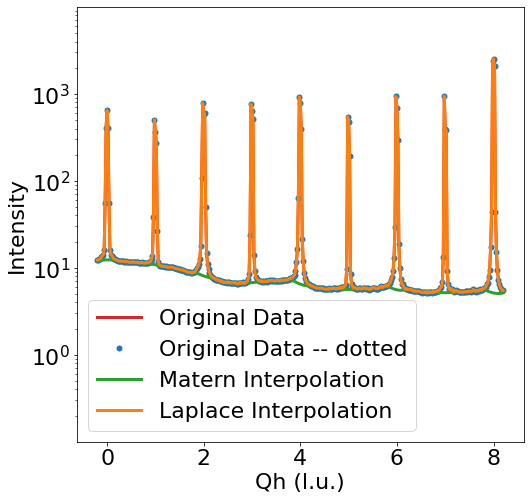

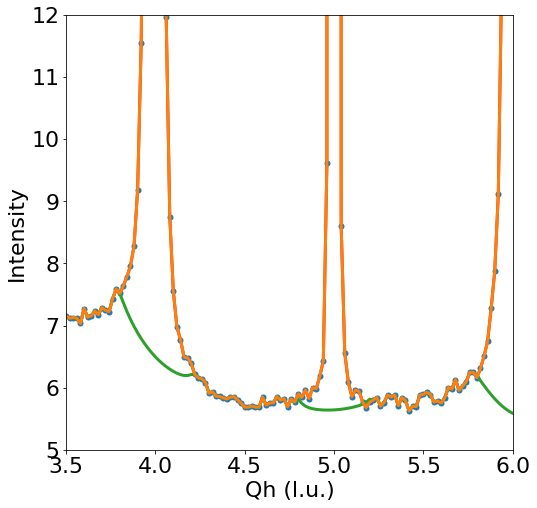

In [13]:
# Taking a 1D slice

# Index in x and y
idx = 60
idy = 60

# Find the maximum of the data on the slice common to both z3d_copy and z3d (are these different?) and add 10 for good measure
max1 = np.max(z3d_copy[idy,idx,:])
max2 = np.max(z3d[idy,idx,:])
max_y = np.max([max1, max2])+10

# Plot original data, matern and laplace interpolations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(8, 8))
plt.semilogy(x3, (z3d[idy, idx, :]), 'tab:red', lw=3)
plt.semilogy(x3, (z3d[idy, idx, :]), 'o', markersize=5, color='tab:blue')
plt.semilogy(x3, (z3d_restored[idy, idx, :]), lw=3, color='tab:green')
plt.semilogy(x3, (parallel_laplace_restored[idy, idx, :]), lw=3, color='tab:orange')
plt.ylim(1e-1, 1e4)
plt.yticks([1, 10, 100, 1000])
#ax[0].set_title("Punch and fill using Laplace and Matern Interpolation")
plt.legend(["Original Data", "Original Data -- dotted","Matern Interpolation", "Laplace Interpolation"])
plt.xlabel('Qh (l.u.)')
plt.ylabel('Intensity')
plt.savefig('Matern_3D_Interpolation.png')

plt.rc('font', **font)
fig = plt.figure(figsize=(8, 8))
plt.plot(x3, (z3d[idy, idx, :]), 'tab:red', lw=3)
plt.plot(x3, (z3d[idy, idx, :]), 'o', markersize=5, color='tab:blue')
plt.plot(x3, (z3d_restored[idy, idx, :]), lw=3, color='tab:green')
plt.plot(x3, (parallel_laplace_restored[idy, idx, :]), lw=3, color='tab:orange')
plt.ylim(5, 12)
plt.xlim(3.5, 6)
plt.xlabel('Qh (l.u.)')
plt.ylabel('Intensity')
#ax[0].set_title("Punch and fill using Laplace and Matern Interpolation")
#plt.legend(["Original Data", "Original Data -- dotted","Matern Interpolation", "Laplace Interpolation"])
plt.savefig('Matern_3D_Interpolation_Zoomed.png')


## Save the Matern and Laplace Interpolated data to an .nxs file 

In [14]:
expt_data = nxload(save_data_dir + 'movo2_40_120K.nxs')['entry'] # or root['entry/masked_transform']

In [15]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored[0:311,0:411,0:411]), name='sphere_punch_matern_interp_data')
root.entry.sphere_matern_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_matern_data.nxs')

In [16]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored_laplace[0:311,0:411,0:411]), name='sphere_punch_laplace_interp_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_laplace_data.nxs')

NameError: name 'z3d_restored_laplace' is not defined

In [ ]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_copy[0:311,0:411,0:411]), name='original_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_original_data.nxs')